In [9]:
# General libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Scikit Learn libraries
from sklearn.model_selection import train_test_split

# Utils functions
from utils.utils import compare_models, plot_score_dist, compare_confidence_intervals, five_two, read_datasets

In [10]:
x_train, x_test, y_train, y_test = read_datasets(
    'x_train.csv',
    'x_test.csv',
    'y_train.csv',
    'y_test.csv'
)

In [11]:
def load_model(model):
    models_folder = '../models/'
    return joblib.load(models_folder + model + '_model.joblib')

In [12]:
#1000 to 10.000 did not show significative differences
#size 2270 based on the paper: https://www.econstor.eu/bitstream/10419/67820/1/587473266.pdf
random_state_list = list(np.random.randint(low = 1,high=5000,size=2270))

## Linear Regression VS SVR

In [13]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.037759
Fold  2 score difference = -0.127961
Fold  1 score difference = -0.124009
Fold  2 score difference = -0.122886
Fold  1 score difference = -0.233174
Fold  2 score difference = -0.118433
Fold  1 score difference = -0.046859
Fold  2 score difference = -0.095336
Fold  1 score difference = -0.164989
Fold  2 score difference = -0.112361
Regression 1 mean score and stdev : 0.043219 + 0.073345
Regression 2 mean score and stdev : 0.161596 + 0.047055
Score difference mean + stdev : -0.118377 + 0.052608
t_value for the current test is -0.734564


mean_score_1 0.05144131033418043, std 0.11138191857137977
mean_score_2 0.21255171337012738, std 0.09866430004292971
Ttest_relResult(statistic=-87.31746483629954, pvalue=0.0)
P value menor ou igual a 0.05


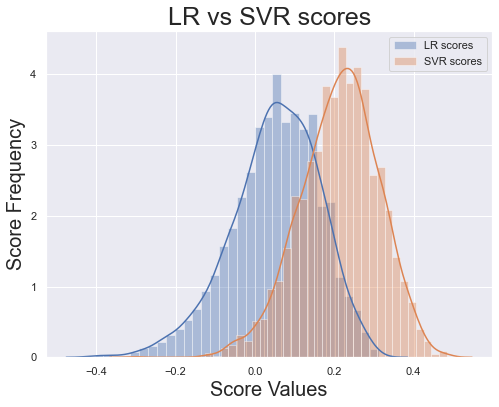

In [14]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('svr'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)


plot_score_dist(reg1_scores, reg2_scores, 'LR', 'SVR')

In [15]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.19737095829471268
0.24707068202382426
0.00443772279954605
0.3897283525516807


## Linear Regression VS XGBoost

In [16]:
five_two(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = -0.031659
Fold  2 score difference = -0.127830
Fold  1 score difference = -0.186219
Fold  2 score difference = -0.061790
Fold  1 score difference = -0.196154
Fold  2 score difference = -0.119880
Fold  1 score difference = -0.014738
Fold  2 score difference = -0.095770
Fold  1 score difference = -0.169992
Fold  2 score difference = -0.107676
Regression 1 mean score and stdev : 0.043219 + 0.073345
Regression 2 mean score and stdev : 0.154390 + 0.023281
Score difference mean + stdev : -0.111171 + 0.059141
t_value for the current test is -0.494438


mean_score_1 0.05144131033418043, std 0.11138191857137977
mean_score_2 0.23072314923336, std 0.07471448000319214
Ttest_relResult(statistic=-101.1079308830867, pvalue=0.0)
P value menor ou igual a 0.05


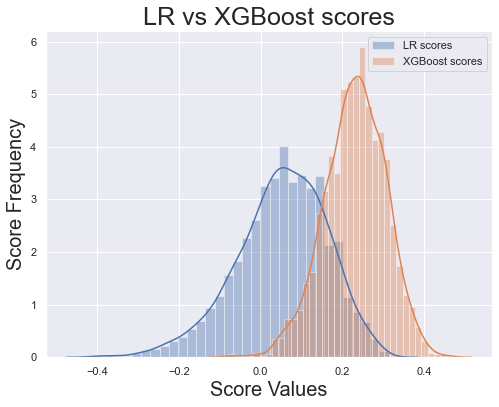

In [17]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('lr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'LR', 'XGBoost')

In [18]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.19737095829471268
0.24707068202382426
0.07108583574499752
0.36719381796003414


## SVR VS XGboost

In [19]:
five_two(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_train.copy(),
    y=y_train.copy(),
    metric='default'
    )

Fold  1 score difference = 0.006100
Fold  2 score difference = 0.000131
Fold  1 score difference = -0.062210
Fold  2 score difference = 0.061096
Fold  1 score difference = 0.037020
Fold  2 score difference = -0.001447
Fold  1 score difference = 0.032121
Fold  2 score difference = -0.000434
Fold  1 score difference = -0.005003
Fold  2 score difference = 0.004685
Regression 1 mean score and stdev : 0.161596 + 0.047055
Regression 2 mean score and stdev : 0.154390 + 0.023281
Score difference mean + stdev : 0.007206 + 0.030939
t_value for the current test is 0.144284


mean_score_1 0.21255171337012738, std 0.09866430004292971
mean_score_2 0.23072314923336, std 0.07471448000319214
Ttest_relResult(statistic=-13.82096982906754, pvalue=8.936608432796944e-42)
P value menor ou igual a 0.05


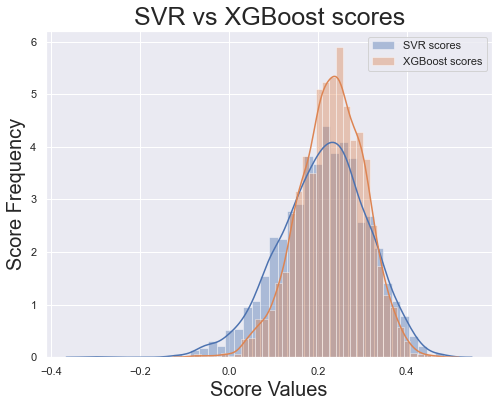

In [20]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [21]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

0.00443772279954605
0.3897283525516807
0.07108583574499752
0.36719381796003414


mean_score_1 -0.5172784059453643, std 0.19010926105832798
mean_score_2 -0.48226515147718446, std 0.143962046835419
Ttest_relResult(statistic=-13.820969829067543, pvalue=8.936608432796307e-42)
P value menor ou igual a 0.05


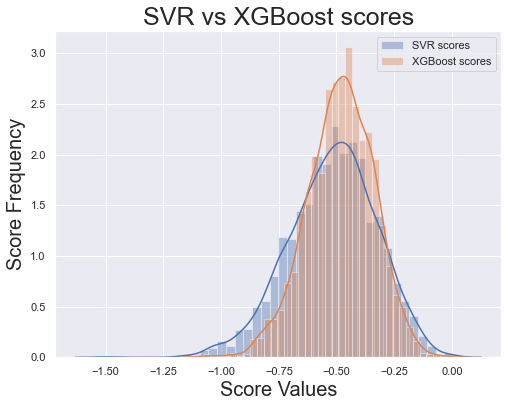

In [22]:
reg1_scores, reg2_scores = compare_models(
    reg1=load_model('svr'),
    reg2=load_model('xgboost'),
    X=x_test.copy(),
    y=y_test.copy(),
    metric="adj_r2",
    random_state_list = random_state_list
)

plot_score_dist(reg1_scores, reg2_scores, 'SVR', 'XGBoost')

In [23]:
compare_confidence_intervals(
    reg1_scores, reg2_scores,
    lower=2.5, upper=97.5
)

-0.918278534117948
-0.17588927191261533
-0.7898589994181755
-0.21930947271115364
